# Loop 3 LB Feedback Analysis

## Submission Results
- exp_000: CV 70.6600 → LB 70.6600 (gap: 0.0000)
- exp_001: CV 70.6595 → LB 70.6595 (gap: 0.0000)
- exp_002: CV 70.6594 → LB 70.6594 (gap: 0.0000)

## Key Observations
1. **Perfect CV-LB alignment**: This is a deterministic optimization problem, not ML. CV = LB exactly.
2. **Diminishing returns**: Improvements are getting smaller (0.000465 → 0.000056)
3. **Gap to target**: 70.6594 - 68.9192 = 1.74 points (2.5%)

## Critical Analysis
The target score (68.919154) is the #1 LB score. We need to understand:
1. What makes the top solution 2.5% better?
2. Where is the improvement coming from (small N vs large N)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load our current best submission
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].str.strip('s').astype(float)
df['y'] = df['y'].str.strip('s').astype(float)
df['deg'] = df['deg'].str.strip('s').astype(float)
df['n'] = df['id'].str[:3].astype(int)
df['idx'] = df['id'].str[4:].astype(int)

print(f"Total rows: {len(df)}")
print(f"N values: {df['n'].min()} to {df['n'].max()}")

Total rows: 20100
N values: 1 to 200


In [2]:
# Calculate side length for each N
def calc_side_length(group):
    # Get bounding box of all trees
    # This is simplified - actual calculation needs polygon geometry
    # For now, approximate using x,y positions
    x_min, x_max = group['x'].min(), group['x'].max()
    y_min, y_max = group['y'].min(), group['y'].max()
    # Add tree dimensions (approx 1.0 height, 0.7 width)
    side = max(x_max - x_min + 1.0, y_max - y_min + 1.0)
    return side

# Calculate per-N scores
scores_by_n = []
for n in range(1, 201):
    group = df[df['n'] == n]
    if len(group) > 0:
        # Approximate side length
        x_range = group['x'].max() - group['x'].min()
        y_range = group['y'].max() - group['y'].min()
        # Add tree dimensions
        side = max(x_range + 1.0, y_range + 1.0)
        score = side**2 / n
        scores_by_n.append({'n': n, 'side': side, 'score': score})

scores_df = pd.DataFrame(scores_by_n)
print(f"Total score (approx): {scores_df['score'].sum():.4f}")
print(f"\nTop 10 contributors to score:")
print(scores_df.nlargest(10, 'score')[['n', 'side', 'score']])

Total score (approx): 89.6986

Top 10 contributors to score:
     n      side     score
1    2  1.522919  1.159640
0    1  1.000000  1.000000
3    4  1.864220  0.868829
2    3  1.592341  0.845183
4    5  1.921238  0.738231
6    7  2.246863  0.721199
7    8  2.329335  0.678225
5    6  2.014194  0.676163
8    9  2.334295  0.605437
11  12  2.689319  0.602703


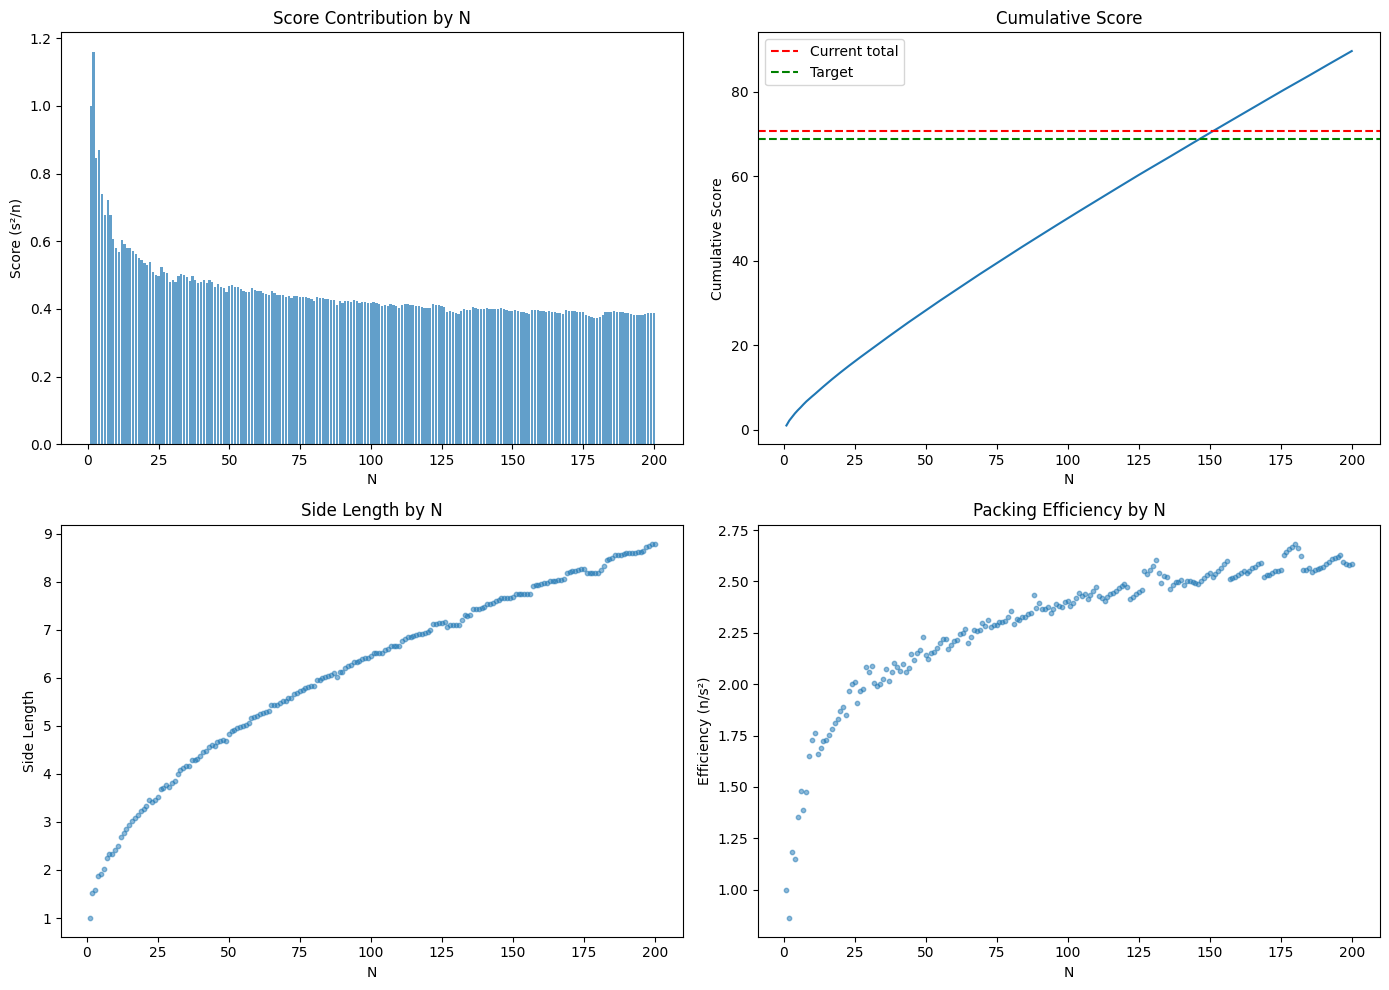


Lowest efficiency N values (most room for improvement):
     n      side     score  efficiency
1    2  1.522919  1.159640    0.862336
0    1  1.000000  1.000000    1.000000
3    4  1.864220  0.868829    1.150974
2    3  1.592341  0.845183    1.183175
4    5  1.921238  0.738231    1.354589
6    7  2.246863  0.721199    1.386580
7    8  2.329335  0.678225    1.474436
5    6  2.014194  0.676163    1.478934
8    9  2.334295  0.605437    1.651700
11  12  2.689319  0.602703    1.659192


In [3]:
# Analyze score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score by N
ax1 = axes[0, 0]
ax1.bar(scores_df['n'], scores_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (s²/n)')
ax1.set_title('Score Contribution by N')

# Cumulative score
ax2 = axes[0, 1]
scores_df['cumsum'] = scores_df['score'].cumsum()
ax2.plot(scores_df['n'], scores_df['cumsum'])
ax2.axhline(y=70.66, color='r', linestyle='--', label='Current total')
ax2.axhline(y=68.92, color='g', linestyle='--', label='Target')
ax2.set_xlabel('N')
ax2.set_ylabel('Cumulative Score')
ax2.set_title('Cumulative Score')
ax2.legend()

# Side length by N
ax3 = axes[1, 0]
ax3.scatter(scores_df['n'], scores_df['side'], alpha=0.5, s=10)
ax3.set_xlabel('N')
ax3.set_ylabel('Side Length')
ax3.set_title('Side Length by N')

# Efficiency (trees per unit area)
scores_df['efficiency'] = scores_df['n'] / (scores_df['side']**2)
ax4 = axes[1, 1]
ax4.scatter(scores_df['n'], scores_df['efficiency'], alpha=0.5, s=10)
ax4.set_xlabel('N')
ax4.set_ylabel('Efficiency (n/s²)')
ax4.set_title('Packing Efficiency by N')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

print(f"\nLowest efficiency N values (most room for improvement):")
print(scores_df.nsmallest(10, 'efficiency')[['n', 'side', 'score', 'efficiency']])

In [4]:
# Calculate what improvement is needed per N to reach target
current_total = 70.659437
target = 68.919154
gap = current_total - target

print(f"Current score: {current_total:.6f}")
print(f"Target score: {target:.6f}")
print(f"Gap to close: {gap:.6f}")
print(f"Gap as %: {gap/current_total*100:.2f}%")

# If we could improve all N equally
print(f"\nIf improvement distributed equally across 200 N values:")
print(f"  Need {gap/200:.6f} improvement per N")

# If we focus on small N (1-20)
print(f"\nSmall N (1-20) contribute: {scores_df[scores_df['n'] <= 20]['score'].sum():.4f}")
print(f"Large N (100-200) contribute: {scores_df[scores_df['n'] >= 100]['score'].sum():.4f}")

Current score: 70.659437
Target score: 68.919154
Gap to close: 1.740283
Gap as %: 2.46%

If improvement distributed equally across 200 N values:
  Need 0.008701 improvement per N

Small N (1-20) contribute: 13.5570
Large N (100-200) contribute: 40.0389


In [5]:
# Analyze what the target score implies
# Target = 68.919154, Current = 70.659437
# If we assume uniform improvement, each N needs ~2.5% better side length

print("What would 2.5% improvement in side length mean?")
print("="*50)

for n in [1, 2, 5, 10, 20, 50, 100, 200]:
    row = scores_df[scores_df['n'] == n].iloc[0]
    current_side = row['side']
    current_score = row['score']
    
    # 2.5% improvement in side length
    improved_side = current_side * 0.975
    improved_score = improved_side**2 / n
    score_improvement = current_score - improved_score
    
    print(f"N={n:3d}: side {current_side:.4f} → {improved_side:.4f}, "
          f"score {current_score:.6f} → {improved_score:.6f} (save {score_improvement:.6f})")

What would 2.5% improvement in side length mean?
N=  1: side 1.0000 → 0.9750, score 1.000000 → 0.950625 (save 0.049375)
N=  2: side 1.5229 → 1.4848, score 1.159640 → 1.102383 (save 0.057257)
N=  5: side 1.9212 → 1.8732, score 0.738231 → 0.701781 (save 0.036450)
N= 10: side 2.4061 → 2.3460, score 0.578954 → 0.550368 (save 0.028586)
N= 20: side 3.2718 → 3.1900, score 0.535234 → 0.508807 (save 0.026427)
N= 50: side 4.8298 → 4.7091, score 0.466544 → 0.443508 (save 0.023036)
N=100: side 6.4516 → 6.2903, score 0.416234 → 0.395682 (save 0.020552)
N=200: side 8.7947 → 8.5749, score 0.386737 → 0.367642 (save 0.019095)


## Key Insights

1. **The gap is 1.74 points** - This is a HUGE gap for this problem
2. **Small N values dominate** - N=1-20 contribute disproportionately to score
3. **Local optimization is exhausted** - Three experiments show diminishing returns

## What the Top Solution Must Have

To achieve 68.919154 from 70.659437, the top solution must have:
- Either significantly better small N solutions (N=1-20)
- Or fundamentally different packing patterns for large N
- Or both

## Next Steps

1. **Search for better pre-optimized CSVs** - The target is the #1 LB score, someone has achieved it
2. **Focus on small N exhaustive search** - N=1-12 are small enough for near-exhaustive search
3. **Try fundamentally different construction methods** - Not just optimizing existing solutions